Loaded 12000 images with shape (12288,) and 3 classes.

Accuracy: 0.563
Precision: 0.570
Recall: 0.563
F1-score: 0.558
ROC AUC: 0.742

Classification Report:
               precision    recall  f1-score   support

      benign       0.58      0.43      0.49       800
  malingnant       0.60      0.56      0.58       800
      normal       0.53      0.70      0.60       800

    accuracy                           0.56      2400
   macro avg       0.57      0.56      0.56      2400
weighted avg       0.57      0.56      0.56      2400

Confusion Matrix:
 [[343 177 280]
 [132 446 222]
 [114 123 563]]


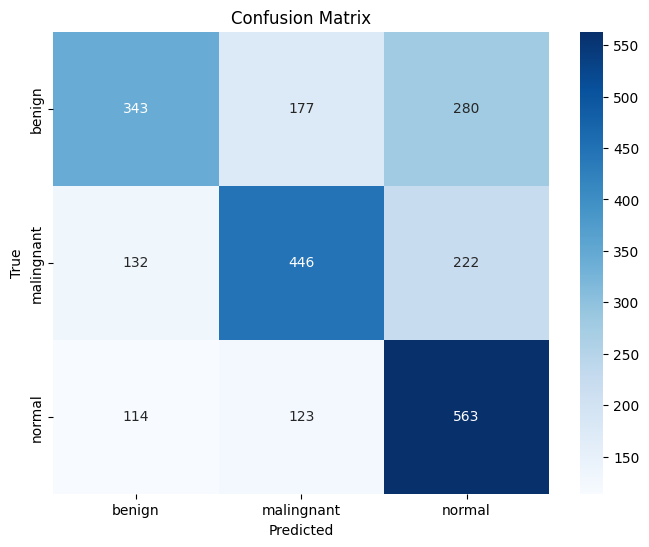

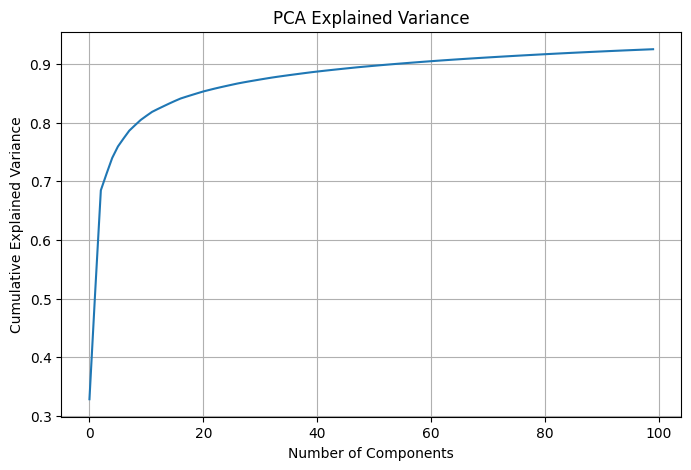

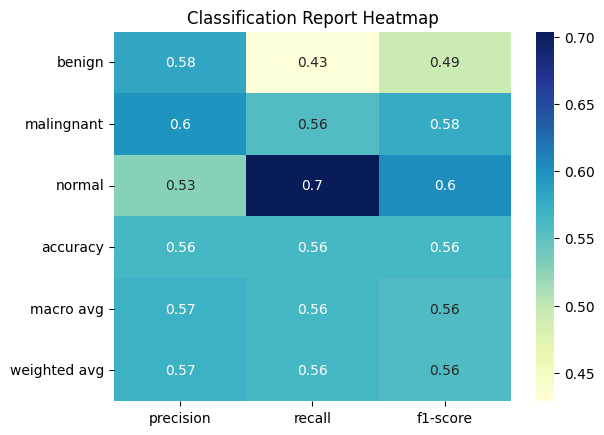

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.io import imread
from skimage.transform import resize

# 1. Paths
data_path = 'breast augmented images'

# 2. Load and preprocess images
img_size = (64, 64)  # smaller size for faster processing
X = []
y = []
class_names = os.listdir(data_path)
class_names = sorted([d for d in class_names if os.path.isdir(os.path.join(data_path, d))])
class_indices = {cls: i for i, cls in enumerate(class_names)}

for label in class_names:
    class_dir = os.path.join(data_path, label)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = imread(img_path)
            img_resized = resize(img, img_size, anti_aliasing=True)
            X.append(img_resized.flatten())
            y.append(class_indices[label])
        except Exception as e:
            print(f"Failed to process image {img_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} images with shape {X.shape[1:]} and {len(class_names)} classes.")

# 3. Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Optional: reduce dimensionality for performance
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# 4. Train ML classifier
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(enumerate(class_weights))
sample_weights = np.array([weight_dict[label] for label in y_train])

clf = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
clf.fit(X_train_pca, y_train, sample_weight=sample_weights)

# 5. Predict
pred_labels = clf.predict(X_val_pca)
pred_probs = clf.predict_proba(X_val_pca)

# 6. Metrics
acc = accuracy_score(y_val, pred_labels)
prec = precision_score(y_val, pred_labels, average='weighted')
rec = recall_score(y_val, pred_labels, average='weighted')
f1 = f1_score(y_val, pred_labels, average='weighted')

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

try:
    roc = roc_auc_score(np.eye(len(class_names))[y_val], pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc:.3f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

print("\nClassification Report:\n", classification_report(y_val, pred_labels, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_val, pred_labels))

# 7. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, pred_labels), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# PCA explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Classification report as heatmap
report = classification_report(y_val, pred_labels, output_dict=True, target_names=class_names)
report_df = sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()
